In [6]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import re
import tqdm
import os
from collections import defaultdict
import re
from pathlib import Path

In [7]:
plt.rcParams.update({
#     'figure.figsize': (6, 4),            # Figure size
#     'figure.dpi': 100,                   # High DPI for publication-quality images
#     'axes.titlesize': 14,                # Title font size
#     'axes.labelsize': 12,                # Axis label font size
#     'axes.labelpad': 10,                 # Padding for labels
#     'axes.linewidth': 1,                 # Axis line width
#     'axes.grid': False,                  # Disable grid unless necessary
#     'xtick.labelsize': 10,               # X-axis tick label size
#     'ytick.labelsize': 10,               # Y-axis tick label size
#     'xtick.major.size': 4,               # Length of major ticks
#     'ytick.major.size': 4,               # Length of major ticks
#     'xtick.major.width': 1,              # Width of major ticks
#     'ytick.major.width': 1,              # Width of major ticks
#     'xtick.direction': 'in',             # Ticks facing inwards
#     'ytick.direction': 'in',             # Ticks facing inwards
#     'legend.fontsize': 10,               # Legend font size
#     'legend.frameon': False,             # Disable legend frame for a cleaner look
    'font.family': 'serif',              # Use a serif font for text
    'font.serif': ['DejaVu Serif'],      # Use 'DejaVu Serif' as the fallback serif font
#     'lines.linewidth': 1.5,              # Line width for plots
#     'lines.markersize': 6,               # Marker size
#     'savefig.dpi': 300,                  # Save figure resolution
#     'savefig.bbox': 'tight',             # Adjust layout to avoid clipping
})

In [24]:
root_path = Path("/home/ritwik/dev/random_needles/exps/mdp")
non_uniforms = [f"non_uniform_mdp_{x:.1f}" for x in np.arange(0.0, 1.1, 0.1)]

# Load the stats data from the folder
model_keys = [
    'google_gemma-2-2b',
    'meta-llama_Llama-3.1-8B',
    'microsoft_phi-2',
    'mistralai_Mistral-7B-v0.3'
]

model_stats_data = {}
for key in tqdm.tqdm(model_keys):
    for non_uniform in non_uniforms:
        if (root_path / non_uniform / key / "stats.pkl").exists():
            with open(root_path / non_uniform / key / "stats.pkl", 'rb') as f:
                model_stats_data[f"{key}/{non_uniform}"] = pickle.load(f)

100%|██████████| 4/4 [01:05<00:00, 16.33s/it]


In [25]:
def tvd(p, q):
    return 0.5 * np.sum(np.abs(p - q))

true_transition = {
    "1": [0.0, 0.5, 0.0, 0.5],
    "2": [0.2, 0.0, 0.8, 0.0],
    "3": [0.1, 0.2, 0.1, 0.6],
    "4": [0.1, 0.1, 0.1, 0.7]
}

In [26]:
model_xys = {}
for model in model_stats_data.keys():
    # Separate the state file into individual trajectories again
    trajectories_trans = [model_stats_data[model][i:i+1000] for i in range(0, len(model_stats_data[model]), 1000)]

    # Keep track of local and global indices for each state
    idxs_trajectory_transition = []
    for global_idx, traj_trans in enumerate(trajectories_trans):
        for local_idx, (state, trans) in enumerate(traj_trans):
            idxs_trajectory_transition.append(
                {"local_idx": local_idx,
                "global_idx": (global_idx * 1000) + local_idx,
                "state": state,
                "transition": trans
                }
            )

    # Average out a transition at local idx {X} if it is observed at that same point across all trajectories
    xy = defaultdict(list)
    for state in ["1", "2", "3", "4"]:
        selected_states = [x for x in idxs_trajectory_transition if x["state"] == state]
        local_group = defaultdict(list)
        for item in selected_states:
            local_group[item["local_idx"]].append(item["transition"])

        for k, v in local_group.items():
            v = np.array(v)
            xy[state].append([k, v.mean(axis=0), v.std(axis=0)])

    # Calculate TVD per time step
    xys = {}
    for state, item in xy.items():
        tvds = []
        for idx, obs_trans_mean, obs_trans_std in item:
            tvds.append((idx, tvd(true_transition[state], obs_trans_mean), obs_trans_std[int(state) - 1]))

        xys[state] = tvds

    model_xys[model] = xys



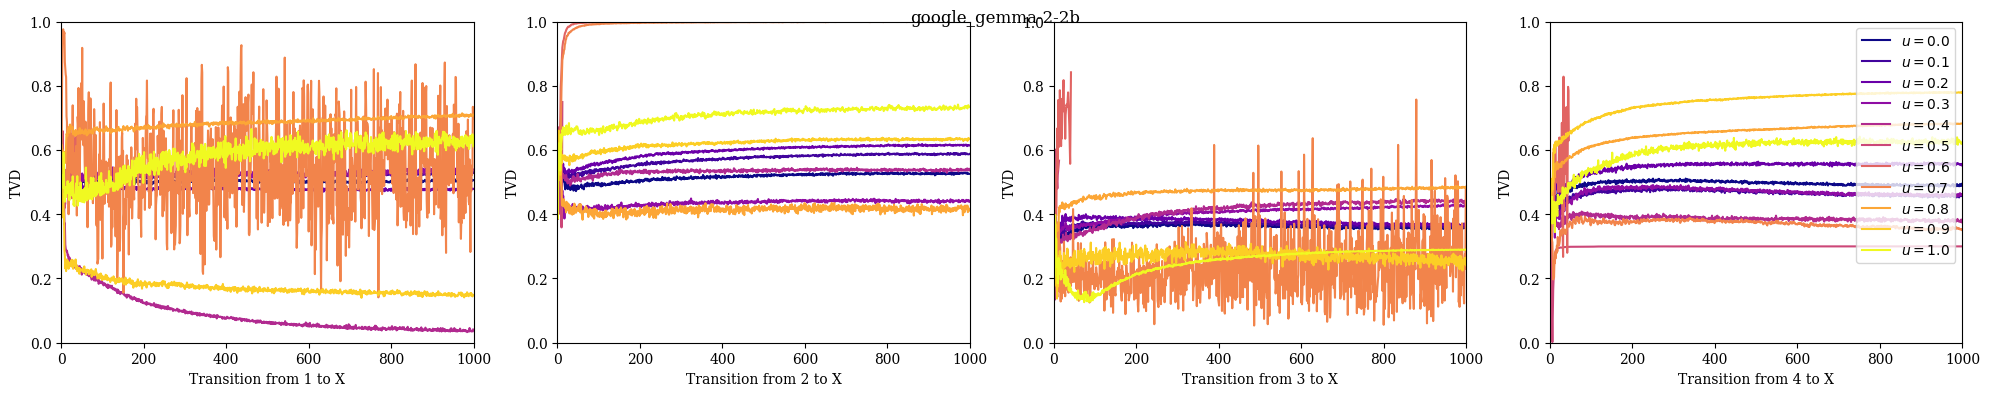

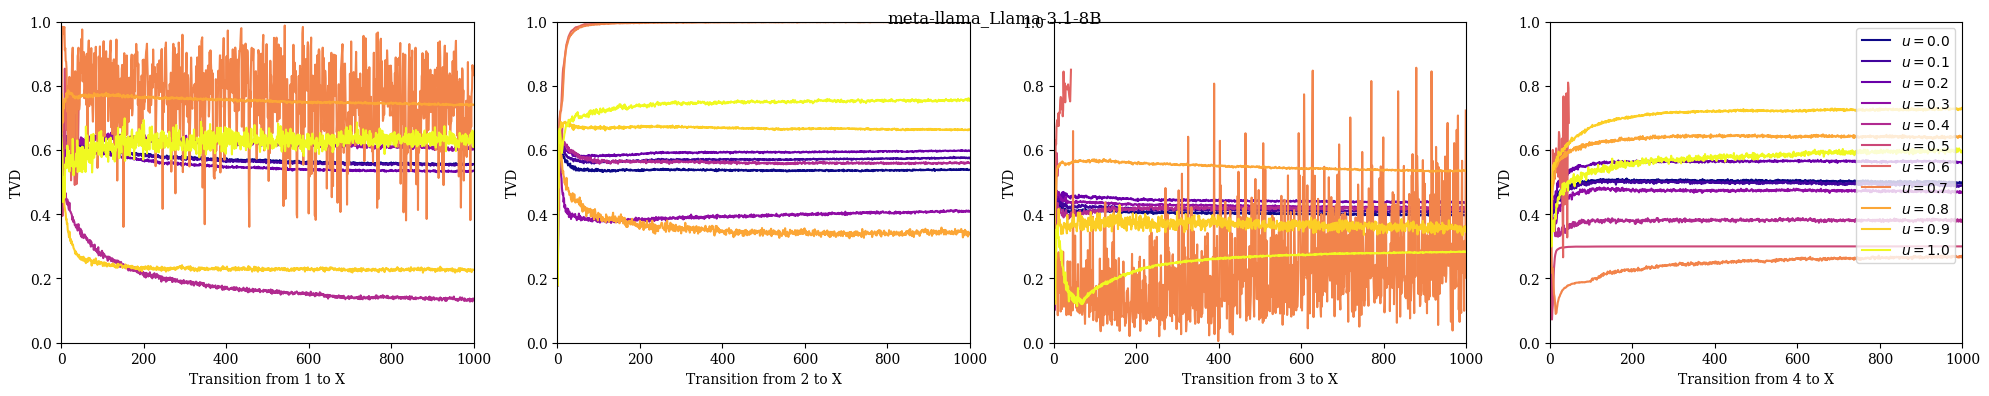

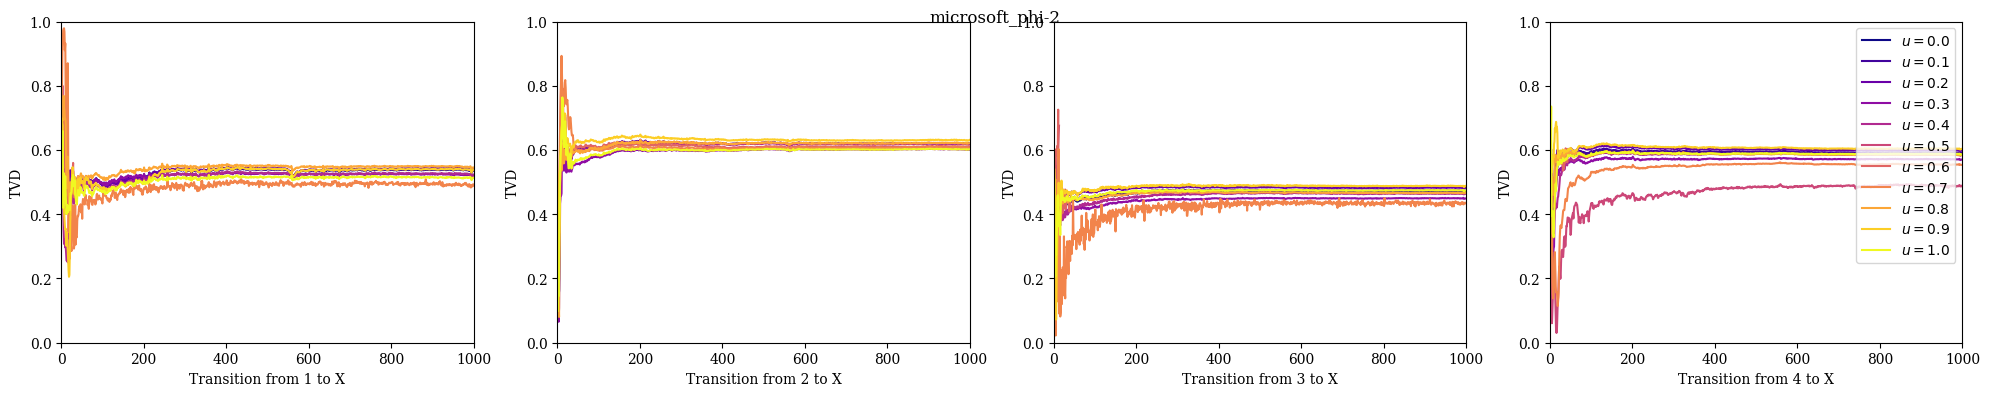

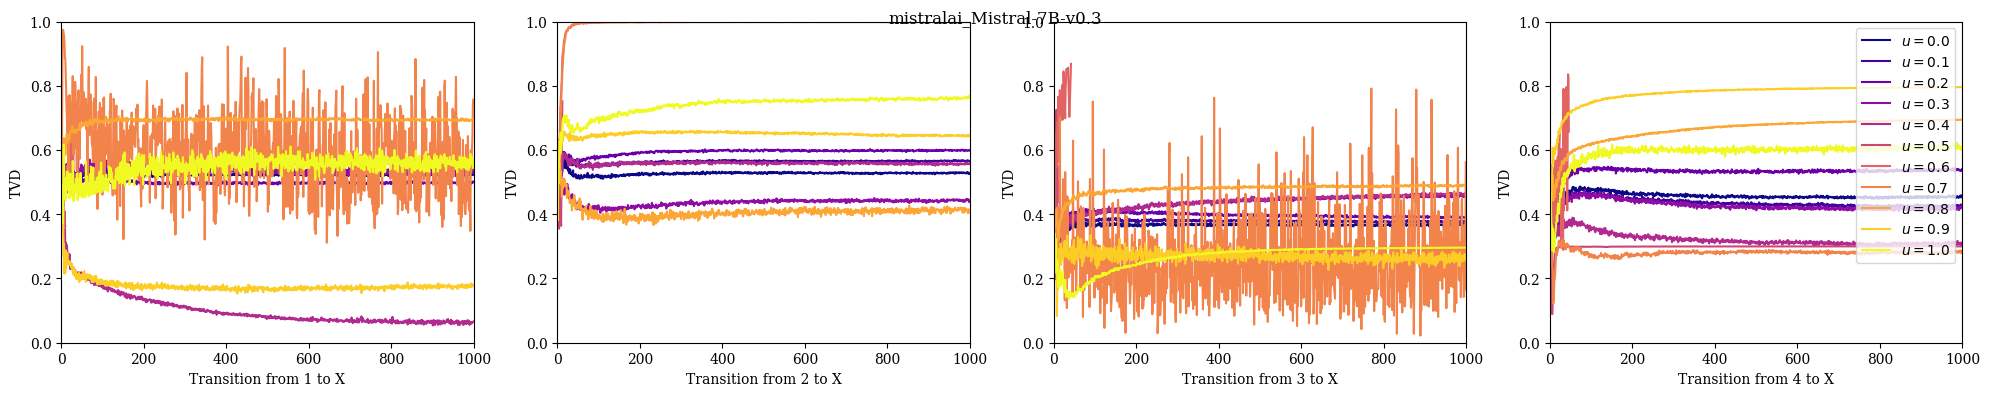

In [27]:
for model in model_keys:
    # Plot
    fig, ax = plt.subplots(1, 4, figsize=(20, 4))
    tvds = defaultdict[list]
    for non_uniform in np.arange(0.0, 1.1, 0.1):
        for idx, state in enumerate(["1", "2", "3", "4"]):
            x, means, stds = zip(*sorted(model_xys[f"{model}/non_uniform_mdp_{non_uniform:.1f}"][state], key=lambda x: x[0]))
            means = np.array(means)
            stds = np.array(stds)
            ax[idx].plot(x, means, label=f"$u={non_uniform:.1f}$", color=plt.cm.plasma(non_uniform))
            # ax[idx].fill_between(x, means - stds, means + stds, alpha=0.2)
            ax[idx].set_xbound([0, 1000])
            ax[idx].set_ybound([0, 1.0])
            ax[idx].set_xlabel(f"Transition from {state} to X")
            ax[idx].set_ylabel("TVD")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.suptitle(f"{model}")

In [7]:
model_data = {}

for model in model_stats_data.keys():
    # Separate the state file into individual trajectories again
    trajectories_trans = [model_stats_data[model][i:i+1000] for i in range(0, len(model_stats_data[model]), 1000)]

    # Keep track of local and global indices for each state
    idxs_trajectory_transition = []
    for global_idx, traj_trans in enumerate(trajectories_trans):
        for local_idx, (state, trans) in enumerate(traj_trans):
            idxs_trajectory_transition.append(
                {"local_idx": local_idx,
                "global_idx": (global_idx * 1000) + local_idx,
                "state": state,
                "transition": trans
                }
            )

    # Average out a transition at local idx {X} if it is observed at that same point across all trajectories
    xy = defaultdict(list)
    for state in ["1", "2", "3", "4"]:
        selected_states = [x for x in idxs_trajectory_transition if x["state"] == state]
        local_group = defaultdict(list)
        for item in selected_states:
            local_group[item["local_idx"]].append(item["transition"])

        for k, v in local_group.items():
            xy[state].append([k, sum(v) / len(v)])

    # Calculate TVD per time step
    xys = {}
    for state, item in xy.items():
        tvds = []
        for idx, obs_trans in item:
            tvds.append((idx, tvd(true_transition[state], obs_trans)))

        xys[state] = tvds

    model_data[model] = {state: list(zip(*sorted(xys[state], key=lambda x: x[0]))) for state in ["1", "2", "3", "4"]}

In [8]:
np.array(model_data['google_gemma-2-2b']["4"][1]).shape

(999,)

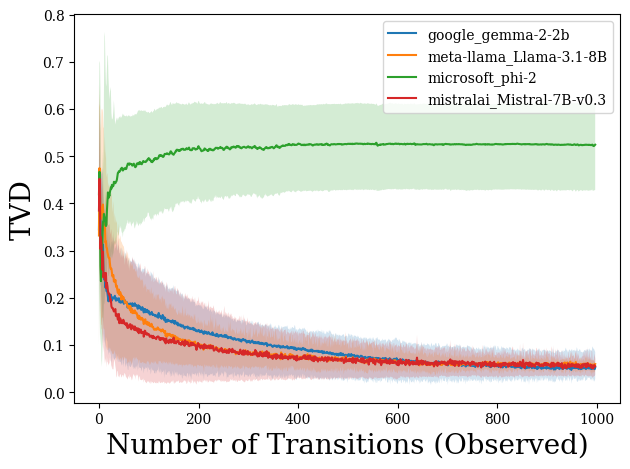

In [12]:
plt.clf()
for model, data in model_data.items():

    data = np.stack([np.array(data[state][1][:998]) for state in ["1", "2", "3", "4"]])
    plt.plot(data.mean(axis=0), label=model)
    plt.fill_between(np.arange(998), data.min(axis=0), data.max(axis=0), alpha=0.2)

plt.legend(loc='upper right')
plt.ylabel('TVD')
plt.xlabel('Number of Transitions (Observed)')
plt.tight_layout()
plt.show()


In [147]:
def generate_non_uniform_matrix_with_row_sums(rows, cols, non_uniformity_factor=0.1):
    """
    Generates a 2D matrix where each row sums to 1, with controllable non-uniformity.

    Parameters:
    - rows: Number of rows in the matrix
    - cols: Number of columns in the matrix
    - non_uniformity_factor: A multiplier for the amount of randomness/non-uniformity. Higher value = more non-uniformity.

    Returns:
    - A 2D numpy array where each row sums to 1.
    """
    # Step 1: Create a base uniform matrix filled with 1/cols, so each row starts as uniform
    base_value = 1.0 / cols
    uniform_matrix = np.full((rows, cols), base_value)

    # Step 2: Add controlled randomness to the base matrix
    # Generate random values in the range (-1, 1) and scale by the non_uniformity_factor
    noise = np.random.uniform(-1, 1, (rows, cols)) * non_uniformity_factor
    
    # Step 3: Add noise to the uniform matrix
    non_uniform_matrix = uniform_matrix + noise

    # Step 4: Normalize each row to sum to 1
    non_uniform_matrix = np.maximum(non_uniform_matrix, 0)  # Ensure no negative values
    row_sums = non_uniform_matrix.sum(axis=1, keepdims=True)
    normalized_matrix = non_uniform_matrix / row_sums  # Normalize each row so that it sums to 1

    return normalized_matrix



array([[0.        , 0.00808568, 0.        , 0.99191432],
       [0.53757243, 0.        , 0.21166046, 0.25076711],
       [0.26094601, 0.42812221, 0.20904771, 0.10188407],
       [0.        , 0.        , 1.        , 0.        ]])

In [192]:
import yaml
np.random.seed(412415)

base_file = yaml.safe_load(open("../configs/exps/mdp/simple_mdp.yaml"))

for non_uniformity_factor in np.arange(0.1, 1.1, 0.1):
    transition_matrix = {}
    transitions = generate_non_uniform_matrix_with_row_sums(4, 4, non_uniformity_factor=non_uniformity_factor)
    for state in [1, 2, 3, 4]:
        transition_matrix[state] = transitions[state - 1].tolist()
    base_file["transition_matrix"] = transition_matrix
    base_file["experiment_dir"] = f"exps/mdp/non_uniform_mdp_{non_uniformity_factor:.1f}"
    yaml.dump(base_file, open(f"../configs/exps/mdp/non_uniform_mdp_{non_uniformity_factor:.1f}.yaml", "w"))